In [1]:
import os
import json
from collections import Counter

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image, ImageOps

import matplotlib.pyplot as plt

# Device (CUDA, Apple MPS, or CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple Silicon
else:
    device = torch.device("cpu")

print("Using device:", device)


Using device: mps


In [2]:
class ClimbingHoldDataset(Dataset):
    """
    Loads climbing holds from COCO-style annotations.
    Returns:
        image: Tensor [3, 224, 224]
        type: int index
        orientation: int index
        indicator: int index
    """

    def __init__(self, annotations_dir, images_dir, transform=None, output_size=(224, 224)):
        self.annotations_dir = annotations_dir
        self.images_dir = images_dir
        self.transform = transform
        self.output_size = output_size

        # Label vocabularies (same mapping everywhere)
        self.types_list = ['Jug', 'Sloper', 'Crimp', 'Jib', 'Pinch', 'Pocket', 'Edge']
        self.orientations_list = ['Up', 'Down', 'Side', 'UpAng', 'DownAng']
        self.indicators_list = ['Path', 'Start', 'Finish']

        self.holds = []

        for file in os.listdir(annotations_dir):
            if not file.endswith(".json"):
                continue

            json_path = os.path.join(annotations_dir, file)
            with open(json_path, "r") as f:
                data = json.load(f)

            images = {img["id"]: img["file_name"] for img in data.get("images", [])}
            annotations = data.get("annotations", [])

            for ann in annotations:
                image_id = ann.get("image_id")
                file_name = images.get(image_id)
                bbox = ann.get("bbox")
                attrs = ann.get("attributes", {}) or {}

                type_label = attrs.get("Type")
                orient_label = attrs.get("Orientation")
                indicator_label = attrs.get("Indicator")

                # Basic checks
                if file_name is None or bbox is None:
                    continue
                if type_label not in self.types_list:
                    continue
                if orient_label not in self.orientations_list:
                    continue
                if indicator_label not in self.indicators_list:
                    continue

                img_path = os.path.join(images_dir, file_name)
                if not os.path.exists(img_path):
                    continue

                self.holds.append({
                    "image_id": file_name,
                    "bbox": bbox,
                    "type": type_label,
                    "orientation": orient_label,
                    "indicator": indicator_label,
                })

        print(f"Loaded {len(self.holds)} valid holds with type, orientation, indicator.")

    def __len__(self):
        return len(self.holds)

    def __getitem__(self, idx):
        hold = self.holds[idx]

        # Load and crop image
        img_path = os.path.join(self.images_dir, hold["image_id"])
        img = Image.open(img_path).convert("RGB")
        img = ImageOps.exif_transpose(img)

        x, y, w, h = hold["bbox"]
        x, y, w, h = map(int, (x, y, w, h))
        img = img.crop((x, y, x + w, y + h))
        img = img.resize(self.output_size)

        if self.transform:
            img = self.transform(img)

        type_idx = self.types_list.index(hold["type"])
        orient_idx = self.orientations_list.index(hold["orientation"])
        indicator_idx = self.indicators_list.index(hold["indicator"])

        return {
            "image": img,
            "type": type_idx,
            "orientation": orient_idx,
            "indicator": indicator_idx,
        }


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

annotations_dir = "data/annotations"
images_dir = "data/images"

dataset = ClimbingHoldDataset(
    annotations_dir=annotations_dir,
    images_dir=images_dir,
    transform=transform,
)

print("Total samples:", len(dataset))

# NumPy arrays of ALL labels in the dataset
type_labels_np = np.array([dataset[i]["type"] for i in range(len(dataset))])
orient_labels_np = np.array([dataset[i]["orientation"] for i in range(len(dataset))])
indicator_labels_np = np.array([dataset[i]["indicator"] for i in range(len(dataset))])

print("type_labels_np shape:", type_labels_np.shape)
print("orientation_labels_np shape:", orient_labels_np.shape)
print("indicator_labels_np shape:", indicator_labels_np.shape)

print("Type distribution:", Counter(type_labels_np))
print("Orientation distribution:", Counter(orient_labels_np))
print("Indicator distribution:", Counter(indicator_labels_np))

# Train/val split
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


Loaded 1605 valid holds with type, orientation, indicator.
Total samples: 1605
type_labels_np shape: (1605,)
orientation_labels_np shape: (1605,)
indicator_labels_np shape: (1605,)
Type distribution: Counter({np.int64(0): 593, np.int64(3): 307, np.int64(1): 232, np.int64(2): 202, np.int64(4): 132, np.int64(6): 127, np.int64(5): 12})
Orientation distribution: Counter({np.int64(0): 766, np.int64(3): 533, np.int64(2): 211, np.int64(4): 54, np.int64(1): 41})
Indicator distribution: Counter({np.int64(0): 1330, np.int64(1): 155, np.int64(2): 120})
Train size: 1284, Val size: 321


In [5]:
from torchvision.models import ResNet18_Weights

class HoldTypeResNet18(nn.Module):
    def __init__(self, num_types=7, pretrained=True):
        super().__init__()
        weights = ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
        self.backbone = models.resnet18(weights=weights)

        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_types)

    def forward(self, x):
        return self.backbone(x)

model = HoldTypeResNet18(num_types=7, pretrained=False).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [7]:
from torchvision.models import ResNet18_Weights

class MultiTaskResNet18(nn.Module):
    def __init__(self, num_types=7, num_orientations=5, num_indicators=3, pretrained=True):
        super().__init__()
        weights = ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
        backbone = models.resnet18(weights=weights)

        in_features = backbone.fc.in_features
        backbone.fc = nn.Identity()  # remove original classifier

        self.backbone = backbone
        self.type_head = nn.Linear(in_features, num_types)
        self.orientation_head = nn.Linear(in_features, num_orientations)
        self.indicator_head = nn.Linear(in_features, num_indicators)

    def forward(self, x):
        feats = self.backbone(x)
        type_logits = self.type_head(feats)
        orientation_logits = self.orientation_head(feats)
        indicator_logits = self.indicator_head(feats)
        return type_logits, orientation_logits, indicator_logits


model = MultiTaskResNet18(
    num_types=7,
    num_orientations=5,
    num_indicators=3,
    pretrained=False,   # if SSL gives you trouble, temporarily set to False
).to(device)

criterion_type = nn.CrossEntropyLoss()
criterion_orientation = nn.CrossEntropyLoss()
criterion_indicator = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [9]:
num_epochs = 10

train_losses = []
val_losses = []

train_acc_type = []
train_acc_orientation = []
train_acc_indicator = []

val_acc_type = []
val_acc_orientation = []
val_acc_indicator = []

for epoch in range(num_epochs):
    # ============================
    # TRAIN
    # ============================
    model.train()
    running_loss = 0.0
    correct_type = 0
    correct_orientation = 0
    correct_indicator = 0
    total = 0

    for batch in train_loader:
        images = batch["image"].to(device)
        labels_type = batch["type"].to(device)
        labels_orientation = batch["orientation"].to(device)
        labels_indicator = batch["indicator"].to(device)

        optimizer.zero_grad()
        out_type, out_orientation, out_indicator = model(images)

        loss_type = criterion_type(out_type, labels_type)
        loss_orientation = criterion_orientation(out_orientation, labels_orientation)
        loss_indicator = criterion_indicator(out_indicator, labels_indicator)

        loss = loss_type + loss_orientation + loss_indicator
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        total += images.size(0)

        preds_type = out_type.argmax(dim=1)
        preds_orientation = out_orientation.argmax(dim=1)
        preds_indicator = out_indicator.argmax(dim=1)

        correct_type += (preds_type == labels_type).sum().item()
        correct_orientation += (preds_orientation == labels_orientation).sum().item()
        correct_indicator += (preds_indicator == labels_indicator).sum().item()

    epoch_train_loss = running_loss / total
    epoch_train_acc_type = correct_type / total
    epoch_train_acc_orientation = correct_orientation / total
    epoch_train_acc_indicator = correct_indicator / total

    train_losses.append(epoch_train_loss)
    train_acc_type.append(epoch_train_acc_type)
    train_acc_orientation.append(epoch_train_acc_orientation)
    train_acc_indicator.append(epoch_train_acc_indicator)

    # ============================
    # VALIDATION
    # ============================
    model.eval()
    val_running_loss = 0.0
    val_correct_type = 0
    val_correct_orientation = 0
    val_correct_indicator = 0
    val_total = 0

    all_val_type_true = []
    all_val_type_pred = []
    all_val_orient_true = []
    all_val_orient_pred = []
    all_val_ind_true = []
    all_val_ind_pred = []

    with torch.no_grad():
        for batch in val_loader:
            images = batch["image"].to(device)
            labels_type = batch["type"].to(device)
            labels_orientation = batch["orientation"].to(device)
            labels_indicator = batch["indicator"].to(device)

            out_type, out_orientation, out_indicator = model(images)

            loss_type = criterion_type(out_type, labels_type)
            loss_orientation = criterion_orientation(out_orientation, labels_orientation)
            loss_indicator = criterion_indicator(out_indicator, labels_indicator)

            loss = loss_type + loss_orientation + loss_indicator
            val_running_loss += loss.item() * images.size(0)

            preds_type = out_type.argmax(dim=1)
            preds_orientation = out_orientation.argmax(dim=1)
            preds_indicator = out_indicator.argmax(dim=1)

            val_correct_type += (preds_type == labels_type).sum().item()
            val_correct_orientation += (preds_orientation == labels_orientation).sum().item()
            val_correct_indicator += (preds_indicator == labels_indicator).sum().item()
            val_total += images.size(0)

            # Save for NumPy arrays
            all_val_type_true.append(labels_type.cpu().numpy())
            all_val_type_pred.append(preds_type.cpu().numpy())
            all_val_orient_true.append(labels_orientation.cpu().numpy())
            all_val_orient_pred.append(preds_orientation.cpu().numpy())
            all_val_ind_true.append(labels_indicator.cpu().numpy())
            all_val_ind_pred.append(preds_indicator.cpu().numpy())

    epoch_val_loss = val_running_loss / val_total
    epoch_val_acc_type = val_correct_type / val_total
    epoch_val_acc_orientation = val_correct_orientation / val_total
    epoch_val_acc_indicator = val_correct_indicator / val_total

    val_losses.append(epoch_val_loss)
    val_acc_type.append(epoch_val_acc_type)
    val_acc_orientation.append(epoch_val_acc_orientation)
    val_acc_indicator.append(epoch_val_acc_indicator)

    # Concatenate NumPy arrays for the *last* epoch
    y_true_type_val = np.concatenate(all_val_type_true)
    y_pred_type_val = np.concatenate(all_val_type_pred)
    y_true_orient_val = np.concatenate(all_val_orient_true)
    y_pred_orient_val = np.concatenate(all_val_orient_pred)
    y_true_ind_val = np.concatenate(all_val_ind_true)
    y_pred_ind_val = np.concatenate(all_val_ind_pred)

    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Train loss: {epoch_train_loss:.4f} | Val loss: {epoch_val_loss:.4f} | "
        f"Train acc [Type:{epoch_train_acc_type:.3f}, "
        f"Orient:{epoch_train_acc_orientation:.3f}, Ind:{epoch_train_acc_indicator:.3f}] | "
        f"Val acc [Type:{epoch_val_acc_type:.3f}, "
        f"Orient:{epoch_val_acc_orientation:.3f}, Ind:{epoch_val_acc_indicator:.3f}]"
    )


Epoch 1/10 | Train loss: 3.7142 | Val loss: 3.5627 | Train acc [Type:0.306, Orient:0.487, Ind:0.805] | Val acc [Type:0.299, Orient:0.492, Ind:0.791]
Epoch 2/10 | Train loss: 3.2317 | Val loss: 3.2873 | Train acc [Type:0.436, Orient:0.499, Ind:0.829] | Val acc [Type:0.399, Orient:0.508, Ind:0.816]
Epoch 3/10 | Train loss: 3.0920 | Val loss: 3.4352 | Train acc [Type:0.472, Orient:0.531, Ind:0.829] | Val acc [Type:0.408, Orient:0.520, Ind:0.801]
Epoch 4/10 | Train loss: 3.0177 | Val loss: 3.2168 | Train acc [Type:0.464, Orient:0.543, Ind:0.833] | Val acc [Type:0.464, Orient:0.502, Ind:0.813]
Epoch 5/10 | Train loss: 2.9677 | Val loss: 3.2404 | Train acc [Type:0.472, Orient:0.540, Ind:0.831] | Val acc [Type:0.452, Orient:0.474, Ind:0.791]
Epoch 6/10 | Train loss: 2.8636 | Val loss: 3.1287 | Train acc [Type:0.504, Orient:0.567, Ind:0.834] | Val acc [Type:0.480, Orient:0.598, Ind:0.816]
Epoch 7/10 | Train loss: 2.8237 | Val loss: 3.2239 | Train acc [Type:0.514, Orient:0.579, Ind:0.831] | Val

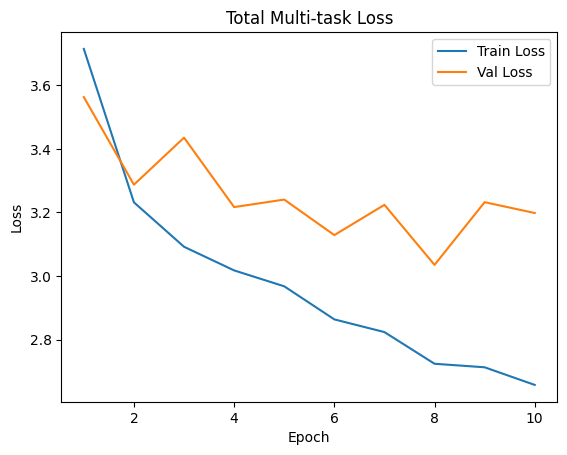

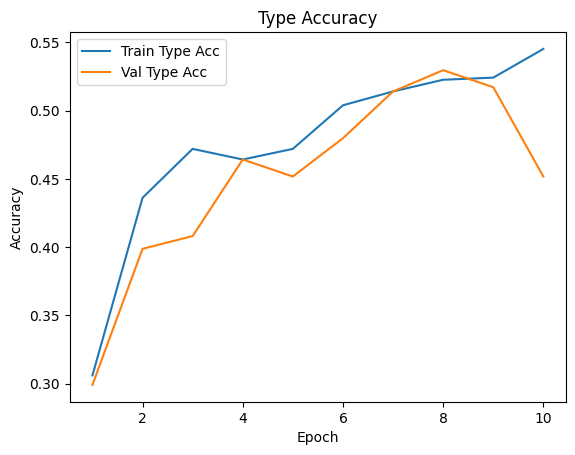

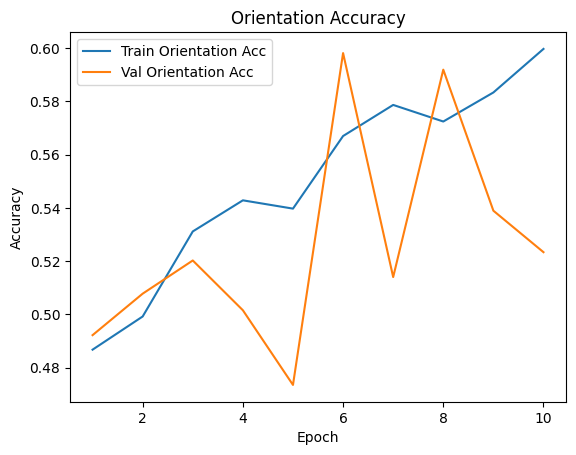

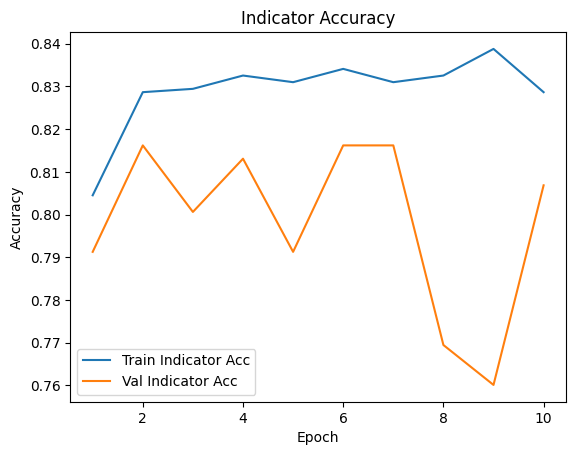

In [12]:
epochs = range(1, num_epochs + 1)

# Loss
plt.figure()
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Total Multi-task Loss")
plt.legend()
plt.show()

# Accuracy - Type
plt.figure()
plt.plot(epochs, train_acc_type, label="Train Type Acc")
plt.plot(epochs, val_acc_type, label="Val Type Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Type Accuracy")
plt.legend()
plt.show()

# Accuracy - Orientation
plt.figure()
plt.plot(epochs, train_acc_orientation, label="Train Orientation Acc")
plt.plot(epochs, val_acc_orientation, label="Val Orientation Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Orientation Accuracy")
plt.legend()
plt.show()

# Accuracy - Indicator
plt.figure()
plt.plot(epochs, train_acc_indicator, label="Train Indicator Acc")
plt.plot(epochs, val_acc_indicator, label="Val Indicator Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Indicator Accuracy")
plt.legend()
plt.show()


In [13]:
print("Final validation accuracy:")
print("Type       :", val_acc_type[-1])
print("Orientation:", val_acc_orientation[-1])
print("Indicator  :", val_acc_indicator[-1])

print("\nDataset label arrays:")
print("type_labels_np shape      :", type_labels_np.shape)
print("orient_labels_np shape    :", orient_labels_np.shape)
print("indicator_labels_np shape :", indicator_labels_np.shape)

print("\nValidation NumPy label/pred arrays (last epoch):")
print("y_true_type_val shape     :", y_true_type_val.shape)
print("y_pred_type_val shape     :", y_pred_type_val.shape)
print("y_true_orient_val shape   :", y_true_orient_val.shape)
print("y_pred_orient_val shape   :", y_pred_orient_val.shape)
print("y_true_ind_val shape      :", y_true_ind_val.shape)
print("y_pred_ind_val shape      :", y_pred_ind_val.shape)


Final validation accuracy:
Type       : 0.4517133956386293
Orientation: 0.5233644859813084
Indicator  : 0.8068535825545171

Dataset label arrays:
type_labels_np shape      : (1605,)
orient_labels_np shape    : (1605,)
indicator_labels_np shape : (1605,)

Validation NumPy label/pred arrays (last epoch):
y_true_type_val shape     : (321,)
y_pred_type_val shape     : (321,)
y_true_orient_val shape   : (321,)
y_pred_orient_val shape   : (321,)
y_true_ind_val shape      : (321,)
y_pred_ind_val shape      : (321,)


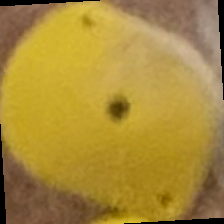

True Type:        Jug | Predicted: Jug
True Orientation: Side | Predicted: Up
True Indicator:   Path | Predicted: Path
--------------------------------------------------


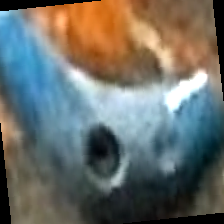

True Type:        Jib | Predicted: Jib
True Orientation: Up | Predicted: Up
True Indicator:   Path | Predicted: Path
--------------------------------------------------


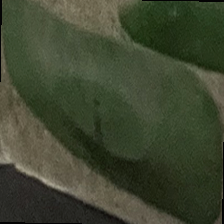

True Type:        Sloper | Predicted: Pinch
True Orientation: Up | Predicted: Up
True Indicator:   Path | Predicted: Path
--------------------------------------------------


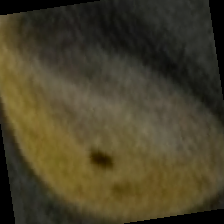

True Type:        Jug | Predicted: Jug
True Orientation: UpAng | Predicted: UpAng
True Indicator:   Path | Predicted: Path
--------------------------------------------------


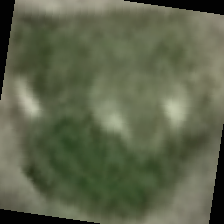

True Type:        Jib | Predicted: Jug
True Orientation: Up | Predicted: Up
True Indicator:   Path | Predicted: Path
--------------------------------------------------


In [15]:
import random

def show_predictions(n=5):
    model.eval()
    for _ in range(n):
        # pick a random sample from the validation subset
        idx = random.randint(0, len(val_dataset) - 1)
        sample = val_dataset[idx]

        img = sample["image"].unsqueeze(0).to(device)

        with torch.no_grad():
            out_type, out_orient, out_ind = model(img)

        pred_type = out_type.argmax(1).item()
        pred_orient = out_orient.argmax(1).item()
        pred_ind = out_ind.argmax(1).item()

        true_type = sample["type"]
        true_orient = sample["orientation"]
        true_ind = sample["indicator"]

        # convert indexes → label names using the *original* dataset
        type_name_true = dataset.types_list[true_type]
        type_name_pred = dataset.types_list[pred_type]

        orient_name_true = dataset.orientations_list[true_orient]
        orient_name_pred = dataset.orientations_list[pred_orient]

        ind_name_true = dataset.indicators_list[true_ind]
        ind_name_pred = dataset.indicators_list[pred_ind]

        # denormalize image for display
        mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)
        denorm_img = sample["image"] * std + mean
        denorm_img = denorm_img.clamp(0, 1)

        img_pil = transforms.ToPILImage()(denorm_img.cpu())

        display(img_pil)
        print(f"True Type:        {type_name_true} | Predicted: {type_name_pred}")
        print(f"True Orientation: {orient_name_true} | Predicted: {orient_name_pred}")
        print(f"True Indicator:   {ind_name_true} | Predicted: {ind_name_pred}")
        print("-" * 50)

# Run it
show_predictions(5)
